Created on December 20th 2020 by Patrick Rotzetter

https://www.linkedin.com/in/rotzetter/

# Small experiment of document mining with various techniques Part 1

In the first part, we will be using spacy for tokenization, parsing and named entity recognition. We will then look at some simple statistics based on spacy results.

In [1]:
#check python version and path
import sys
sys.executable

'/opt/anaconda3/envs/base38/bin/python'

In [2]:
#import main libraries
import numpy as np
import PyPDF2
import spacy
import pandas as pd
import re
from pptx import Presentation
import pdftotext
import texthero as hero

In [3]:
#  validate spacy language models just in case, this command does not work on Mac ARM systems unless you have installed the brew workaround and reinstalled python
!python -m spacy validate

✔ Loaded compatibility table

====================== Installed models (spaCy v2.3.5) ======================
ℹ spaCy installation:
/opt/anaconda3/envs/base38/lib/python3.8/site-packages/spacy

TYPE      NAME             MODEL            VERSION                            
package   en-core-web-sm   en_core_web_sm   2.3.1   ✔
package   en-core-web-lg   en_core_web_lg   2.3.1   ✔



In [4]:
# function to read PDF files using PYPdf2
def readPdfFilePY(filename):
    text=""
    read_pdf = PyPDF2.PdfFileReader(filename,'rb')   
    for i in range(read_pdf.getNumPages()):
        page = read_pdf.getPage(i)
        txt=page.extractText()
        text=text+txt
    return text


In [5]:
# function to read PDF files using pdftotext
def readPdfFile(filename):
    text=""
    with open(filename, "rb") as f:
        pdf = pdftotext.PDF(f)
        for page in pdf:
            text=text+page
    return text

In [6]:
# function to read PPT files
def readPPTFile(filename):
    text=""  
    prs = Presentation(filename)
    for slide in prs.slides:
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                text=text+shape.text
    text=remove_special_characters(text)
    return text

In [7]:
#path of first input test file
path='./sampledocs/'
docFile = path+'Technology-and-innovation-in-the-insurance-sector.pdf' 

In [8]:
#read the PDF File
 
textFromPdf=readPdfFile(docFile)
len(textFromPdf)

127312

In [9]:
# print the start of file to check we have read it correctly
print(textFromPdf[0:100])

Technology and
innovation in the
insurance sector
TECHNOLOGY AND INNOVATION
  IN THE INSURANCE SEC


In [10]:
#path of second input file
docFile = path+'Digital-disruption-in-Insurance.pdf' 

In [11]:
#read the second PDF file   
textFromPdf2=readPdfFile(docFile)
len(textFromPdf2)

464271

In [12]:
# print the file to check we have read it correctly
print(textFromPdf2[0:100])

Digital disruption
in insurance:
Cutting through
the noise
     Contents
      Preface								     


## Process files with spacy and calculate their similarity

In [13]:
# load spacy with large English model
# nlp = spacy.load("en-core-web-lg") -- was working on Windows, but now on a Mac
import en_core_web_lg
nlp = en_core_web_lg.load()

In [14]:
# let us process the 2 files using spacy pipeline
docpdf1=nlp(textFromPdf)
docpdf2=nlp(textFromPdf2)

In [15]:
# let us check the document vector shape
docpdf1.vector.shape

(300,)

In [16]:
# calculate document similarity with spacy function
docpdf1.similarity(docpdf2)

0.9921302780761528

In [17]:
# document similarity can also be calculated by multiplying the document vectors. we will use this later on
np.dot(docpdf1.vector,docpdf2.vector)

6.7858405

## Process all directory files with spacy

In [18]:
# helper function to process documents in an apply function and return the nlp object
def processDoc(doc):
    return nlp(doc)

In [19]:
# let us scan the full directory, read PDF and PPT documents, clean them and process them with spacy

docName=[]
docType=[]
docText=[]
docNLP=[]
import glob
list_of_files = glob.glob(path+'*.pdf')           # create the list of file
fileNames=[]
for file_name in list_of_files:
    fileText=readPdfFile(file_name)
    docName.append(file_name)
    docType.append('pdf')
    docText.append(fileText)
list_of_files = glob.glob(path+'*.pptx')           # create the list of file
for file_name in list_of_files:
    fileText=readPPTFile(file_name)
    docName.append(file_name)
    docType.append('ppt')
    docText.append(fileText)
fullDocs = pd.DataFrame({'Name':docName,'Type':docType,'Text':docText})
fullDocs['cleanText']=hero.clean(fullDocs['Text'])
fullDocs['NLP']=fullDocs['cleanText'].apply(processDoc)

In [20]:
 print ("Average length of text:" + str((np.mean(fullDocs['Text'].str.len()))))
 print ("Min length of text:" + str((np.min(fullDocs['Text'].str.len()))))
 print ("Max length of text:" + str((np.max(fullDocs['Text'].str.len()))))

Average length of text:173026.0
Min length of text:17987
Max length of text:464271


In [21]:
fullDocs['text_word_count'] = fullDocs['Text'].apply(lambda x: len(x.strip().split()))  # word count
fullDocs['text_unique_words']=fullDocs['Text'].apply(lambda x:len(set(str(x).split())))  # number of unique words
fullDocs.head()

,Name,Type,Text,cleanText,NLP,text_word_count,text_unique_words
0,./sampledocs/ai-360-research.pdf,pdf,AI 360: insights from the\nnext frontier of bu...,ai insights next frontier business corner offi...,"(ai, insights, next, frontier, business, corne...",5289,1752
1,./sampledocs/Module-1-Lecture-Slides.pdf,pdf,"Application of AI, Insurtech and Real Estate\n...",application ai insurtech real estate technolog...,"(application, ai, insurtech, real, estate, tec...",3732,1509
2,./sampledocs/Technology-and-innovation-in-the-...,pdf,Technology and\ninnovation in the\ninsurance s...,technology innovation insurance sector technol...,"(technology, innovation, insurance, sector, te...",16763,4237
3,./sampledocs/sigma-5-2020-en.pdf,pdf,No 5 /2020\n\n\n\n\n...,machine intelligence executive summary machine...,"(machine, intelligence, executive, summary, ma...",14512,4342
4,./sampledocs/_content_dam_Deloitte_de_Document...,pdf,From mystery to mastery:\nUnlocking the busine...,mystery mastery unlocking business value artif...,"(mystery, mastery, unlocking, business, value,...",11032,3457


In [22]:
fullDocs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               10 non-null     object
 1   Type               10 non-null     object
 2   Text               10 non-null     object
 3   cleanText          10 non-null     object
 4   NLP                10 non-null     object
 5   text_word_count    10 non-null     int64 
 6   text_unique_words  10 non-null     int64 
dtypes: int64(2), object(5)
memory usage: 688.0+ bytes


In [23]:
fullDocs.describe()

,text_word_count,text_unique_words
count,10.000000,10.000000
mean,17238.100000,4083.700000
std,14729.007181,2398.566797
min,2502.000000,1006.000000
25%,6724.750000,2178.250000
50%,14951.000000,3961.000000
75%,18329.000000,5075.500000
max,49779.000000,8462.000000


## Word count and most common words and nouns

In [24]:
# let us look most used words for each part of speech
from collections import defaultdict, Counter

posCounts = defaultdict(Counter)

for doc in fullDocs.NLP:
    for token in doc:
        posCounts[token.pos][token.orth] += 1

for pos_id, counts in sorted(posCounts.items()):
    pos = doc.vocab.strings[pos_id]
    for orth_id, count in counts.most_common(1):
        print(pos, count, doc.vocab.strings[orth_id])

ADJ 557 digital
ADP 147 across
ADV 453 also
AUX 16 get
CCONJ 37 yet
DET 78 another
INTJ 30 ai
NOUN 1522 data
NUM 238 one
PART 529 '
PRON 41 us
PROPN 688 ai
PUNCT 967 "
SCONJ 77 whether
SYM 4 x
VERB 451 based
X 44 etc


In [25]:
# add some common words to stop wordds that may not add much context
from spacy.lang.en.stop_words import STOP_WORDS
customStopWords = [
    'insurance','insurer','customer','technology','datum']

for w in customStopWords:
    if w not in STOP_WORDS:
        STOP_WORDS.add(w)

In [26]:
# get most common nouns
from collections import defaultdict, Counter
from spacy.symbols import nsubj, VERB, dobj, NOUN, root, xcomp, PROPN, NUM,SYM
# all tokens that arent stop words or punctuations
words=[]
for doc in fullDocs.NLP:
    words += [token.lemma_ for token in doc if token.pos==NOUN and (not token.lemma_ in STOP_WORDS)] 
# five most common tokens
wordFreq = Counter(words)
commonWords = wordFreq.most_common(20)
print(commonWords)

[('business', 537), ('risk', 521), ('system', 496), ('right', 493), ('product', 450), ('company', 431), ('example', 425), ('use', 418), ('consumer', 376), ('case', 374), ('data', 371), ('service', 370), ('model', 364), ('value', 326), ('information', 324), ('process', 320), ('decision', 312), ('impact', 285), ('claim', 279), ('protection', 270)]


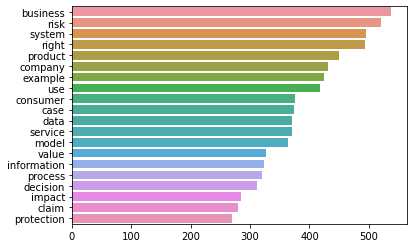

In [27]:
import seaborn as sns


def displayEntitiesChart(commonEntities,n=20, save=False, saveToFile='test.jpg'):
    x, y= [], []
    for word,count in commonEntities[:n]:
            x.append(word)
            y.append(count)
        
    plot= sns.barplot(x=y,y=x)
    if save:
        fig = plot.get_figure()
        fig.savefig(saveToFile)
displayEntitiesChart(commonWords)

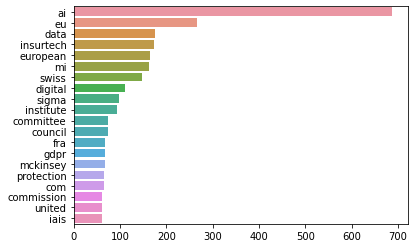

In [28]:
# get most common proper nouns
from collections import defaultdict, Counter
from spacy.symbols import nsubj, VERB, dobj, NOUN, root, xcomp, PROPN, NUM,SYM
# all tokens that arent stop words or punctuations
words=[]
for doc in fullDocs.NLP:
    
    words += [token.lemma_ for token in doc if token.pos==PROPN and (not token.lemma_ in STOP_WORDS)\
             and (len(token)>1)] 


# five most common tokens
wordFreq = Counter(words)
commonWords = wordFreq.most_common(20)
displayEntitiesChart(commonWords)

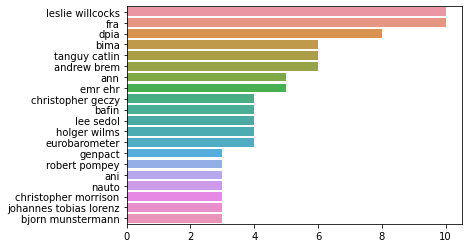

In [30]:
# most frequest PERSON entities
entities=[]
for doc in fullDocs.NLP:
    # all entities
    for ent in doc.ents:
        #print(ent.text)
        if ent.label_ == 'PERSON':
            if ent.text not in STOP_WORDS:
                entities += [ent.text]
entityFreq = Counter(entities)
commonEntities = entityFreq.most_common(40)
displayEntitiesChart(commonEntities)

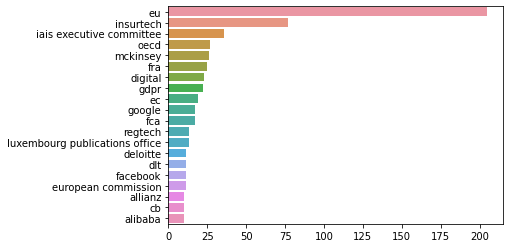

In [32]:
# most frequest ORG entities
entities=[]
for doc in fullDocs.NLP:
    # all entities
    for ent in doc.ents:
        #print(ent.text)
        if ent.label_ == 'ORG':
            if ent.text not in STOP_WORDS:
                entities += [ent.text]
entityFreq = Counter(entities)
commonEntities = entityFreq.most_common(40)
displayEntitiesChart(commonEntities,20,True,'spacy23.jpg')